In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy import interpolate

In [3]:
input_path = '/Volumes/Behaviour/S1 2P Recordings for Suite2P'
output_path = '/Volumes/Behaviour/Tailored 3sec 2P Trials Up-sampled'
beh_stim = pd.read_csv('/Volumes/Behaviour/stimframes.csv', index_col=0)

In [47]:
# WITH UP-SAMPLING
directories = [x[0] for x in os.walk(input_path) if os.path.basename(x[0]) == 'plane0']

for directory in directories:
    print('Processing:', directory)
    stop = False
    meta = directory.split('/')  #directory.split('\\') 
    session_name = meta[4] #meta[3] 
    print(session_name)
    
    # load Suite2P outputs
    F = np.load(os.path.join(directory, 'F.npy'))
    Fneu = np.load(os.path.join(directory, 'Fneu.npy'))
    iscell = np.load(os.path.join(directory,'iscell.npy'), allow_pickle=True)
                             
    # read trial timings
    sf_path = meta[0]+'/'+meta[1]+'/'+meta[2]+'/'+meta[3] +'/'+ meta[4]
    sf = pd.read_csv(os.path.join(sf_path, '2P_stimframes.csv'))
    sf = sf.drop(sf.index[sf['stim_qc'] == 'removed']) # discard 2p timings for trials where behaviour videos were deleted because of qc
    cols = list(sf.columns)
    temp_stim = beh_stim[beh_stim['identifier'].str.contains(str(cols[0]))] # subset stimframes to the session being processed
    
    stimuli = list(sf['stimulus'])
    
    for s, stimulus in enumerate(stimuli):
        temp2_stim = temp_stim[temp_stim['identifier'].str.contains(str(stimulus))] # subset to one stimulus
        values = list(temp2_stim['sframe']) # get list of stimframes for one stimulus
        ids = list(temp2_stim['identifier'])
        sf.loc[sf['stimulus']==stimulus,'sframe']  = values
        sf.loc[sf['stimulus']==stimulus, 'identifier'] = ids
        
    sf_qc = sf.drop(sf.index[sf['sframe'] == 'DO NOT USE']) # keep only trials that passed behavioural qc
    sf_qc = sf_qc[~sf_qc[session_name].isnull()] # remove trial without 2P recording
    sf_qc['beh_stim_ms'] = (sf_qc['sframe'].astype(int)*2.5)+2.5 # convert behaviour stimulation frame to msec and add offset (1 frame in ms)
    sf_qc['2p_realstim_frame'] = sf_qc[session_name] + ((sf_qc['beh_stim_ms'] - 163.9) / 163.9)
    sf_qc['2p_realstim_frame'] = sf_qc['2p_realstim_frame'].apply(np.ceil) # round up to next completed frame
    
    sf_qc.to_csv(os.path.join(sf_path, '2P_SF_QC.csv'))
    
    stimframes = np.array(sf_qc['2p_realstim_frame'])
    idx = list(sf_qc['identifier'])
    
    # Subtract neuropil signal from raw traces
    Fc = F - 0.7 * Fneu
    print('matrix shape: ', F.shape)
    
    # Get list of ROIS that are not cells
    iscell = pd.DataFrame(iscell)
    iscell_idx = iscell[0] == 1
    
    # Remove non-cell ROIs from raw traces & raw traces without neuropil
    df_F = pd.DataFrame(F)
    F_isCell = df_F.loc[iscell_idx]
    
    df_Fc = pd.DataFrame(Fc)
    Fc_isCell = df_Fc.loc[iscell_idx]
                             
    # remove ROIs with zero values from raw traces and get new list of indecis corresponding to active ROIs
    F_nonZero = F_isCell.loc[~(F_isCell==0).all(axis=1)]
    activeROIs = list(F_nonZero.index.values)
    print('number of active rois: ', len(activeROIs))

    # keep only active ROIs in F-neuropil
    Fc_Act = df_Fc.loc[df_Fc.index[activeROIs]]
    print('active rois matrix shape: ', Fc_Act.shape)
                             
    if stimframes[0]-183 <0: # determine appropriate length of pre-stimulus baseline based on the number 
        TBL_len = stimframes[0]-1 # of frames available before the very first stimulation
    else:
        TBL_len = 183 # default baseline is 30 s (30 * 6.1 fps = 183)
        
# for each active ROI, calculate 5th percentile, then cut out 30 sec pre-, and 60 sec post-stimulation 
# traces and use these to calculate F0 (I call it T0 since it is trial based) as the mean of Q5 in the trial window.
# Then, compute trial-wise dF_F0 (I called them dT_T0) an crop those to a 3 second window centered sround stimulation.

    dF_F0_UP = pd.DataFrame()
    for r, roi in enumerate(activeROIs):
       
        Fc_Q05 = Fc_Act.iloc[r,:].rolling(366, center = True).quantile(0.05) # 5th percentile of neuropil-corrected F trace
        
        tailored_up = pd.DataFrame()
        
        for s in stimframes:
            start = int(s) - int(TBL_len)
            end = int(s) + 366 # 60 sec * 6.1 fps
            T = Fc_Act.iloc[r,start:end] # trial window of neuropil-corrected F trace
            T_Q05 = Fc_Q05.iloc[start:end] # trial window of 5th percentile trace
            T0 = T_Q05.mean()
            dT_T0_long = (T - T0)/T0
            
            start_short = int(s) - 10  # adding extra frame for upsampling to behaviour frame rate
            end_short = int(s) + 9
            dT_T0_short = dT_T0_long.loc[start_short:end_short]
            #print('2P trace length: ', len(dT_T0_short))
            # up-sample neural recording to beahviour frame rate (400fps)
            x = np.arange(1/6.1, 21/6.1, 1/6.1)
            y_samples = np.array(dT_T0_short)
            x = np.array(x)
            xnew = np.arange(1/6.1, 20/6.1, 1/400)
            f = interpolate.interp1d(x, y_samples,kind='linear')
            ynew = f(xnew)
            dT_T0_up = pd.DataFrame(ynew[:-2])
            #print('up-sampled length: ', len(dT_T0_up))
            tailored_up = pd.concat([tailored_up, dT_T0_up], axis=0)
            
        new_name = session_name + '_' + str(roi)
        dF_F0_UP[new_name] = tailored_up[0]
    
    print('last trial length: ', dT_T0_up.shape) # checking length of last trial in frames
    
    # add identifier column to dF_F0 dataframes 
    ids = []
    for i in idx:
        for n in range(1244):
            ids.append(i)                                       
    ids = np.array(ids) 
    
    dF_F0_UP['identifier'] = ids
 
    dF_F0_UP.to_csv(os.path.join(output_path,'dF_F0_SHORT_UP_' +session_name+'.csv'))

Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P06_Ses01/suite2p/plane0
2P06_Ses01
matrix shape:  (1040, 17959)
number of active rois:  358
active rois matrix shape:  (358, 17959)


/Users/aspra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


last trial length:  (1244, 1)


/Users/aspra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P06_Ses02/suite2p/plane0
2P06_Ses02
matrix shape:  (1191, 18865)
number of active rois:  373
active rois matrix shape:  (373, 18865)
last trial length:  (1244, 1)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P06_Ses03/suite2p/plane0
2P06_Ses03
matrix shape:  (1101, 19950)
number of active rois:  283
active rois matrix shape:  (283, 19950)
last trial length:  (1244, 1)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P05_Ses04/suite2p/plane0
2P05_Ses04
matrix shape:  (1106, 18259)
number of active rois:  330
active rois matrix shape:  (330, 18259)
last trial length:  (1244, 1)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P06_Ses04/suite2p/plane0
2P06_Ses04
matrix shape:  (1362, 19757)
number of active rois:  364
active rois matrix shape:  (364, 19757)
last trial length:  (1244, 1)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P06_Ses05/suite2p/plane0
2P06_Ses05
matrix 

last trial length:  (1244, 1)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P09_Ses05/suite2p/plane0
2P09_Ses05
matrix shape:  (1377, 22535)
number of active rois:  652
active rois matrix shape:  (652, 22535)
last trial length:  (1244, 1)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P10_Ses05/suite2p/plane0
2P10_Ses05
matrix shape:  (1265, 19272)
number of active rois:  606
active rois matrix shape:  (606, 19272)
last trial length:  (1244, 1)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P11_Ses06/suite2p/plane0
2P11_Ses06
matrix shape:  (1141, 17788)
number of active rois:  464
active rois matrix shape:  (464, 17788)
last trial length:  (1244, 1)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P11_CFA/suite2p/plane0
2P11_CFA
matrix shape:  (1422, 17787)
number of active rois:  537
active rois matrix shape:  (537, 17787)
last trial length:  (1244, 1)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P05_Ses01/suite2p

In [21]:
# JUST CREATING NEW TAILORED TTRIALS WITH EXTRA BASELINE FRAME (20 frames)
output_path = '/Volumes/Behaviour/Tailored 3sec 20 frames'
directories = [x[0] for x in os.walk(input_path) if os.path.basename(x[0]) == 'plane0']

for directory in directories:
    print('Processing:', directory)
    stop = False
    meta = directory.split('/')  #directory.split('\\') 
    session_name = meta[4] #meta[3] 
    print(session_name)
    
    # load Suite2P outputs
    F = np.load(os.path.join(directory, 'F.npy'))
    Fneu = np.load(os.path.join(directory, 'Fneu.npy'))
    iscell = np.load(os.path.join(directory,'iscell.npy'), allow_pickle=True)
                             
    # read trial timings
    sf_path = meta[0]+'/'+meta[1]+'/'+meta[2]+'/'+meta[3] +'/'+ meta[4]
    sf = pd.read_csv(os.path.join(sf_path, '2P_stimframes.csv'))
    sf = sf.drop(sf.index[sf['stim_qc'] == 'removed']) # discard 2p timings for trials where behaviour videos were deleted because of qc
    cols = list(sf.columns)
    temp_stim = beh_stim[beh_stim['identifier'].str.contains(str(cols[0]))] # subset stimframes to the session being processed
    
    stimuli = list(sf['stimulus'])
    
    for s, stimulus in enumerate(stimuli):
        temp2_stim = temp_stim[temp_stim['identifier'].str.contains(str(stimulus))] # subset to one stimulus
        values = list(temp2_stim['sframe']) # get list of stimframes for one stimulus
        ids = list(temp2_stim['identifier'])
        sf.loc[sf['stimulus']==stimulus,'sframe']  = values
        sf.loc[sf['stimulus']==stimulus, 'identifier'] = ids
        
    sf_qc = sf.drop(sf.index[sf['sframe'] == 'DO NOT USE']) # keep only trials that passed behavioural qc
    sf_qc = sf_qc[~sf_qc[session_name].isnull()] # remove trial without 2P recording
    sf_qc['beh_stim_ms'] = (sf_qc['sframe'].astype(int)*2.5)+2.5 # convert behaviour stimulation frame to msec and add offset (1 frame in ms)
    sf_qc['2p_realstim_frame'] = sf_qc[session_name] + ((sf_qc['beh_stim_ms'] - 163.9) / 163.9)
    sf_qc['2p_realstim_frame'] = sf_qc['2p_realstim_frame'].apply(np.ceil) # round up to next completed frame
    
    sf_qc.to_csv(os.path.join(sf_path, '2P_SF_QC.csv'))
    
    stimframes = np.array(sf_qc['2p_realstim_frame'])
    idx = list(sf_qc['identifier'])
    
    # Subtract neuropil signal from raw traces
    Fc = F - 0.7 * Fneu
    print('matrix shape: ', F.shape)
    
    # Get list of ROIS that are not cells
    iscell = pd.DataFrame(iscell)
    iscell_idx = iscell[0] == 1
    
    # Remove non-cell ROIs from raw traces & raw traces without neuropil
    df_F = pd.DataFrame(F)
    F_isCell = df_F.loc[iscell_idx]
    
    df_Fc = pd.DataFrame(Fc)
    Fc_isCell = df_Fc.loc[iscell_idx]
                             
    # remove ROIs with zero values from raw traces and get new list of indecis corresponding to active ROIs
    F_nonZero = F_isCell.loc[~(F_isCell==0).all(axis=1)]
    activeROIs = list(F_nonZero.index.values)
    print('number of active rois: ', len(activeROIs))

    # keep only active ROIs in F-neuropil
    Fc_Act = df_Fc.loc[df_Fc.index[activeROIs]]
    print('active rois matrix shape: ', Fc_Act.shape)
                             
    if stimframes[0]-183 <0: # determine appropriate length of pre-stimulus baseline based on the number 
        TBL_len = stimframes[0]-1 # of frames available before the very first stimulation
    else:
        TBL_len = 183 # default baseline is 30 s (30 * 6.1 fps = 183)
        
# for each active ROI, calculate 5th percentile, then cut out 30 sec pre-, and 60 sec post-stimulation 
# traces and use these to calculate F0 (I call it T0 since it is trial based) as the mean of Q5 in the trial window.
# Then, compute trial-wise dF_F0 (I called them dT_T0) an crop those to a 3 second window centered sround stimulation.

    dF_F0_20 = pd.DataFrame()
    for r, roi in enumerate(activeROIs):
       
        Fc_Q05 = Fc_Act.iloc[r,:].rolling(366, center = True).quantile(0.05) # 5th percentile of neuropil-corrected F trace
        
        tailored_20 = pd.DataFrame()
        
        for s in stimframes:
            start = int(s) - int(TBL_len)
            end = int(s) + 366 # 60 sec * 6.1 fps
            T = Fc_Act.iloc[r,start:end] # trial window of neuropil-corrected F trace
            T_Q05 = Fc_Q05.iloc[start:end] # trial window of 5th percentile trace
            T0 = T_Q05.mean()
            dT_T0_long = (T - T0)/T0
            
            start_short = int(s) - 10  # adding extra frame for upsampling to behaviour frame rate
            end_short = int(s) + 9
            dT_T0_20 = dT_T0_long.loc[start_short:end_short]
            tailored_20 = pd.concat([tailored_20, dT_T0_20], axis=0)
            
        new_name = session_name + '_' + str(roi)
        dF_F0_20[new_name] = tailored_20[0]
    
    print('last trial length: ', dT_T0_20.shape) # checking length of last trial in frames
    
    # add identifier column to dF_F0 dataframes 
    ids = []
    for i in idx:
        for n in range(20):
            ids.append(i)                                       
    ids = np.array(ids) 
    
    dF_F0_20['identifier'] = ids
 
    dF_F0_20.to_csv(os.path.join(output_path,'dF_F0_20_' +session_name+'.csv'))

Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P06_Ses01/suite2p/plane0
2P06_Ses01
matrix shape:  (1040, 17959)
number of active rois:  358
active rois matrix shape:  (358, 17959)


/Users/aspra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


last trial length:  (20,)


/Users/aspra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P06_Ses02/suite2p/plane0
2P06_Ses02
matrix shape:  (1191, 18865)
number of active rois:  373
active rois matrix shape:  (373, 18865)
last trial length:  (20,)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P06_Ses03/suite2p/plane0
2P06_Ses03
matrix shape:  (1101, 19950)
number of active rois:  283
active rois matrix shape:  (283, 19950)
last trial length:  (20,)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P05_Ses04/suite2p/plane0
2P05_Ses04
matrix shape:  (1106, 18259)
number of active rois:  330
active rois matrix shape:  (330, 18259)
last trial length:  (20,)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P06_Ses04/suite2p/plane0
2P06_Ses04
matrix shape:  (1362, 19757)
number of active rois:  364
active rois matrix shape:  (364, 19757)
last trial length:  (20,)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P06_Ses05/suite2p/plane0
2P06_Ses05
matrix shape:  (867, 20

matrix shape:  (1377, 22535)
number of active rois:  652
active rois matrix shape:  (652, 22535)
last trial length:  (20,)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P10_Ses05/suite2p/plane0
2P10_Ses05
matrix shape:  (1265, 19272)
number of active rois:  606
active rois matrix shape:  (606, 19272)
last trial length:  (20,)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P11_Ses06/suite2p/plane0
2P11_Ses06
matrix shape:  (1141, 17788)
number of active rois:  464
active rois matrix shape:  (464, 17788)
last trial length:  (20,)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P11_CFA/suite2p/plane0
2P11_CFA
matrix shape:  (1422, 17787)
number of active rois:  537
active rois matrix shape:  (537, 17787)
last trial length:  (20,)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P05_Ses01/suite2p/plane0
2P05_Ses01
matrix shape:  (1294, 8615)
number of active rois:  259
active rois matrix shape:  (259, 8615)
last trial length:  (20,)
Pro

In [20]:
dF_F0_20

,2P06_Ses01_0,2P06_Ses01_1,2P06_Ses01_2,2P06_Ses01_3,2P06_Ses01_4,2P06_Ses01_5,2P06_Ses01_6,2P06_Ses01_7,2P06_Ses01_8,2P06_Ses01_9,...,2P06_Ses01_865,2P06_Ses01_870,2P06_Ses01_888,2P06_Ses01_903,2P06_Ses01_911,2P06_Ses01_930,2P06_Ses01_938,2P06_Ses01_943,2P06_Ses01_965,identifier
385,0.010434,0.018868,0.015410,0.010855,0.003218,0.044839,0.002471,0.003913,0.002767,0.010993,...,0.001795,0.022574,0.005992,0.002122,0.001543,0.002256,0.001313,0.000224,0.008097,2P06_Ses01_26OCT2021_pin-prick_Trial_1_57352
386,0.002567,0.028457,0.012142,0.011000,0.007504,0.004021,0.004834,0.000946,0.009586,0.012094,...,-0.000531,0.010418,0.005238,0.003352,0.007900,0.002986,0.000890,0.002239,0.006184,2P06_Ses01_26OCT2021_pin-prick_Trial_1_57352
387,0.009817,0.009335,0.016606,0.005767,0.004945,0.035025,0.003488,0.007053,0.015225,0.014288,...,0.001440,0.008009,0.007732,0.002462,0.006154,0.001639,0.003028,0.000609,0.004867,2P06_Ses01_26OCT2021_pin-prick_Trial_1_57352
388,0.021391,0.039865,0.006621,0.010235,0.004892,0.026385,0.004871,0.012004,0.016863,0.024368,...,0.000693,0.008692,0.010884,0.000202,0.002472,-0.000667,0.001196,0.001517,0.007960,2P06_Ses01_26OCT2021_pin-prick_Trial_1_57352
389,0.007714,0.007868,0.009037,0.016467,0.007555,0.008232,0.004656,0.019474,0.011472,0.008254,...,0.001040,-0.000733,0.004664,0.003413,0.006844,0.003878,0.001427,0.000927,0.009803,2P06_Ses01_26OCT2021_pin-prick_Trial_1_57352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17596,0.034028,0.043487,0.014281,0.001291,0.005503,-0.006797,0.007583,0.012266,0.005038,0.024261,...,0.003330,0.009099,0.002611,0.004699,0.003082,0.006271,0.005964,0.002736,0.009281,2P06_Ses01_26OCT2021_opto_Trial_3_46579
17597,0.030644,0.046574,0.014654,-0.004966,0.017521,0.034671,0.012276,0.013330,0.000223,0.019677,...,0.003116,0.014848,0.001834,-0.001068,0.003401,0.004584,0.008132,0.001324,0.010854,2P06_Ses01_26OCT2021_opto_Trial_3_46579
17598,0.024161,0.028697,0.015902,0.007744,0.016325,0.030458,0.007949,0.020057,0.004316,0.020591,...,0.003197,0.005877,0.001151,-0.000099,0.003581,0.005181,0.004496,0.001811,0.015447,2P06_Ses01_26OCT2021_opto_Trial_3_46579
17599,0.014547,0.028306,0.016227,0.008131,0.010591,0.036305,0.003557,0.019807,0.000307,0.008805,...,0.002120,0.000546,0.001481,0.004046,0.003950,0.005704,0.006400,0.002589,0.014815,2P06_Ses01_26OCT2021_opto_Trial_3_46579


In [16]:
24*20

480

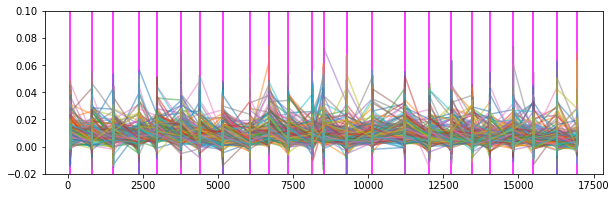

In [25]:
plt.figure(figsize=(10, 3))
plt.plot(dF_F0_short.iloc[:,50:200], alpha=0.5)
#plt.plot(dF_F0_short, alpha=0.5)
plt.ylim([-0.02,0.1])
#plt.xlim([350,400])
plt.eventplot(stimframes, color = 'fuchsia', linelength = 800)
plt.show()

In [23]:
F.shape

(995, 17235)